<a href="https://www.kaggle.com/code/luisprezsala/batman?scriptVersionId=91054137" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Práctica 1: Análisis exporatorio de datos
---
Minería de Datos

Máster en Ciencia de Datos

Universidad de Alicante

Integrantes:
- Carlos Osman Suazo
- Enrique Morales
- Luis Pérez-Sala
- Alejandro Panagiotidis Arrizabalaga

# Justificación y objetivos
---

En esta primera práctica se nos pidio buscar una serie de datos y realizar un proceso de análisis sobre estos. El tema seleccionado es bucar si existe alguna relación entre el número de centros educativos (colegios y universidades) con los incidentes registrados por la policia en los diferentes distritos de la ciudad de San Francisco. El objetivo de esta práctica es el de poder extraer información relevante de dicho conjunto de datos.

In [1]:
######## Install Libraries ########
!pip install squarify
!pip install plotly

In [2]:
######## Loading Files ########
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
from wordcloud import WordCloud
import spacy
import plotly.express as px

DATASET_PATH = '../input/sanfranciscopolicedepartmentincidentreports/'
INCIDENTS_FILE = 'Police_Department_Incident_Reports__2018_to_Present.csv'
SCHOOLS_FILE  = 'Schools.csv'
COLLEGES_FILE = 'Schools_College.csv' 

incidents_df = pd.read_csv(DATASET_PATH + INCIDENTS_FILE)
schools_df   = pd.read_csv(DATASET_PATH + SCHOOLS_FILE)
colleges_df  = pd.read_csv(DATASET_PATH + COLLEGES_FILE)

# Análisis exploratorio
---

In [3]:
print(f'Incidentes data:\n Filas= {incidents_df.shape[0]} \t Columnas= {incidents_df.shape[1]}\n')
print(f'Escuelas (Schools) data:\n Filas= {schools_df.shape[0]} \t Columnas= {schools_df.shape[1]}\n')
print(f'Universidades (Colleges) data:\n Filas= {colleges_df.shape[0]} \t Columnas= {colleges_df.shape[1]}\n')

Incidentes data:
 Filas= 566245 	 Columnas= 34

Escuelas (Schools) data:
 Filas= 445 	 Columnas= 21

Universidades (Colleges) data:
 Filas= 46 	 Columnas= 8



# Preprocesado de datos
---

En este apartado se realizará el proprocesado de los datos, esto nos permitirá a partir

## Incidentes

In [4]:
# Eliminamos las siguientes columnas 
incidents_df = incidents_df.drop(['Row ID', 'Incident ID', 'Incident Number', 
                                  'CAD Number', 'Report Type Code', 
                                  'Report Type Description', 'Filed Online', 
                                  'CNN', 'Analysis Neighborhood', 
                                  'ESNCAG - Boundary File', 'Neighborhoods',
                                  'HSOC Zones as of 2018-06-05', 
                                  'Invest In Neighborhoods (IIN) Areas',
                                  'Civic Center Harm Reduction Project Boundary', # No existe información de esta columna
                                  'Central Market/Tenderloin Boundary Polygon - Updated'], # No existe información de esta columna
                                 axis=1)

## Universidades

In [5]:
# Eliminamos las columnas: 
# webaddress, campus, phone, st_area_sh y st_length_
colleges_df = colleges_df.drop(['webaddress', 'campus', 'phone', 
                                'st_area_sh', 'st_length_'], axis=1)
# Renombramos las columnas: 
# the_geom -> geom_coordinates
# institutio -> college_name
colleges_df =colleges_df.rename(columns={'the_geom': 'geom_coordinates', 
                                         'institutio': 'college_name'})
colleges_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   geom_coordinates  46 non-null     object
 1   college_name      46 non-null     object
 2   address           46 non-null     object
dtypes: object(3)
memory usage: 1.2+ KB


## Colegios

In [6]:
# Obener las coordenadas de la escuela
# Nos quedamos con las coordenadas separadas por coma
schools_df['Location 1'] = schools_df['Location 1'].str.strip('CA\n()') 

# Separamos la cadena a partir de la coma y asignamos cada valor
# a una nueva columna Latitud y longitud
schools_df[['Latitude', 'Longitude']] = schools_df['Location 1'].str.split(', ', expand=True)

# Convertimos las columnas 'Latitude' y 'Longitude' a tipo float
schools_df[['Latitude', 'Longitude']] = schools_df[['Latitude', 'Longitude']].astype(float)

# Eliminamos la columna 'Location 1' junto con otras que no ofrecen 
# información relevante para el análisis.
schools_df = schools_df.drop(columns=['Location 1', 'Map Label', 'CDS Code', 
                                      'General Type', 'County Name', 
                                      'Neighborhoods (old)', 'Zip Codes'], 
                             axis=1)
schools_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Campus Name                445 non-null    object 
 1   CCSF Entity                445 non-null    object 
 2   Lower Grade                445 non-null    int64  
 3   Upper Grade                445 non-null    int64  
 4   Grade Range                445 non-null    object 
 5   Category                   445 non-null    object 
 6   Lower Age                  445 non-null    int64  
 7   Upper Age                  445 non-null    int64  
 8   Campus Address             445 non-null    object 
 9   Supervisor District        445 non-null    int64  
 10  County FIPS                445 non-null    int64  
 11  Fire Prevention Districts  443 non-null    float64
 12  Police Districts           438 non-null    float64
 13  Supervisor Districts       445 non-null    int64  

# Serie temporal: Evolución del número de incidentes por año y mes

<AxesSubplot:title={'center':'Número de incidentes por Mes/Año'}, xlabel='Mes', ylabel='Número de incidentes'>

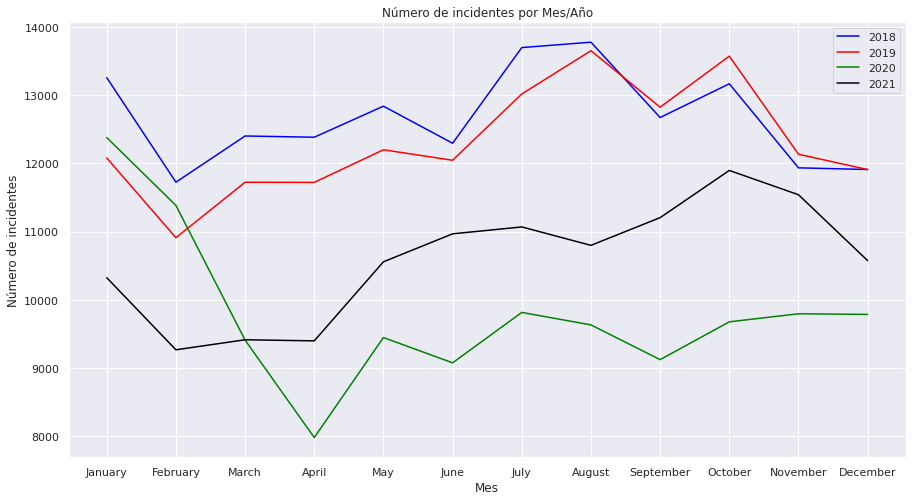

In [7]:
incidents_df['Incident Datetime'] = pd.to_datetime(incidents_df['Incident Datetime'])
incidents_df['Report Datetime'] = pd.to_datetime(incidents_df['Report Datetime'])
incidents_df = incidents_df.sort_values('Incident Datetime')

incidents_2018 = incidents_df[incidents_df['Incident Datetime'].between('2018-01-01', '2018-12-31')]
incidents_2019 = incidents_df[incidents_df['Incident Datetime'].between('2019-01-01', '2019-12-31')]
incidents_2020 = incidents_df[incidents_df['Incident Datetime'].between('2020-01-01', '2020-12-31')]
incidents_2021 = incidents_df[incidents_df['Incident Datetime'].between('2021-01-01', '2021-12-31')]
incidents_2022 = incidents_df[incidents_df['Incident Datetime'].between('2022-01-01', '2022-12-31')]

# incidents_2022.groupby(by=[incidents_2022.index.month,incidents_2022.index.year])
monthly_2018 = incidents_2018.groupby(incidents_2018['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2019 = incidents_2019.groupby(incidents_2019['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2020 = incidents_2020.groupby(incidents_2020['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2021 = incidents_2021.groupby(incidents_2021['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2022 = incidents_2022.groupby(incidents_2022['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()

months_sorted = sorted(monthly_2021.keys(), key=lambda day: datetime.strptime(day, "%B"))

test_2018 = [] 
test_2019 = []
test_2020 = []
test_2021 = []
test_2022 = []

for month in months_sorted:
    test_2018.append(monthly_2018[month])
    test_2019.append(monthly_2019[month])
    test_2020.append(monthly_2020[month])
    test_2021.append(monthly_2021[month])
#     if monthly_2022[month]: test_2022.append(monthly_2022[month])

sns.set_theme(style="darkgrid")

sns.set(rc={'figure.figsize':(15,8)})

plt.title("Número de incidentes por Mes/Año")
plt.xlabel("Mes")
plt.ylabel("Número de incidentes")

sns.lineplot(x=months_sorted, y=test_2018, color='blue',  legend='brief', label=str('2018'))
sns.lineplot(x=months_sorted, y=test_2019, color='red',   legend='brief', label=str('2019'))
sns.lineplot(x=months_sorted, y=test_2020, color='green', legend='brief', label=str('2020'))
sns.lineplot(x=months_sorted, y=test_2021, color='black', legend='brief', label=str('2021'))

# Comparación incidentes época COVID-19/No-COVID-19

Observando la serie temporal anterior apreciamos que el número de incidentes de la época del confinamiento debido al COVID-19 entre los meses TAL Y TAL del año 2020 y los del año anterior varían considerablemente como es lógico. Analizaremos qué tipos de incidente ocurrieron durante esta etapa de confinamiento y los compararemos con los del año anterior.

<AxesSubplot:xlabel='count', ylabel='Incident Category'>

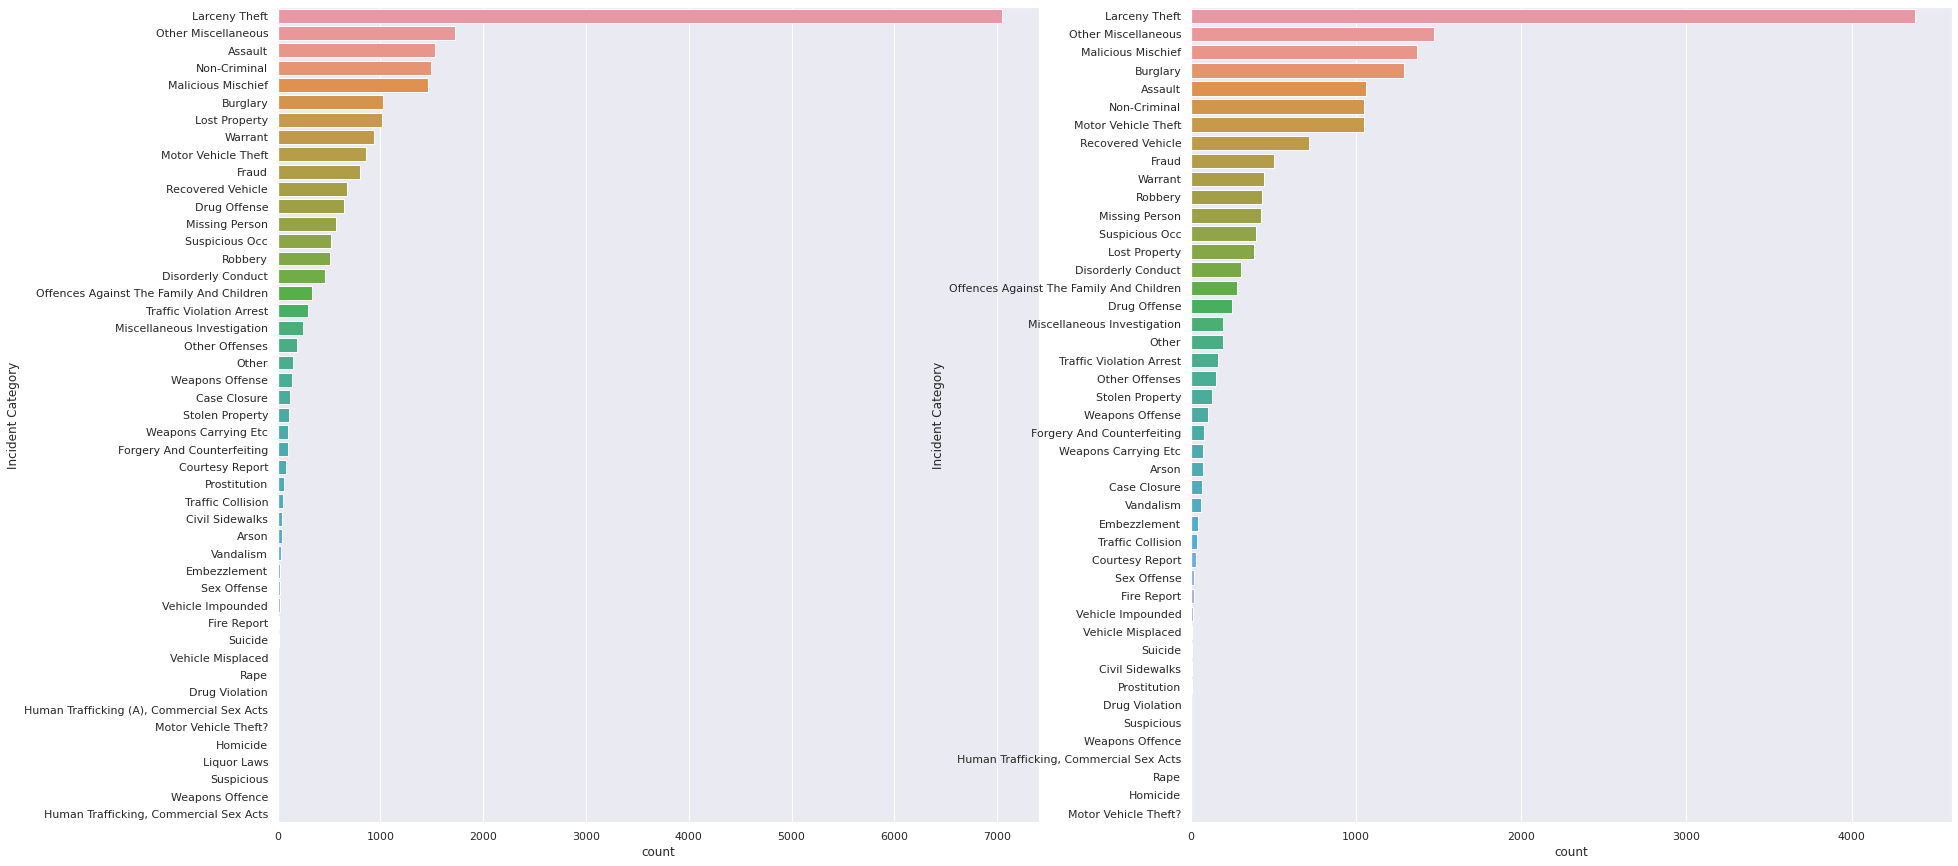

In [8]:
############ COVID ############
covid_epoch = incidents_2020[incidents_2020['Incident Datetime'].between('2020-03-01', '2020-05-01')]
not_covid_epoch = incidents_2019[incidents_2019['Incident Datetime'].between('2019-03-01', '2019-05-01')]

covid_order = pd.Categorical(covid_epoch['Incident Category'].value_counts().index)
not_covid_order = pd.Categorical(not_covid_epoch['Incident Category'].value_counts().index)

sns.set(rc={'figure.figsize':(30,15)})
fig, ax =plt.subplots(1,2)
sns.countplot(data=not_covid_epoch, y="Incident Category", order = not_covid_order, ax=ax[0])
sns.countplot(data=covid_epoch, y="Incident Category", order = covid_order, ax=ax[1])

# Comparación incidentes Febrero/Octubre 2021

Debido a que en la gráfica temporal mostrada anteriormente se aprecia que en el año 2021 se producen muchos más incidentes en octubre que en febrero, analizaremos qué tipo de incidentes se cometen en ambos periodos.

<AxesSubplot:xlabel='count', ylabel='Incident Category'>

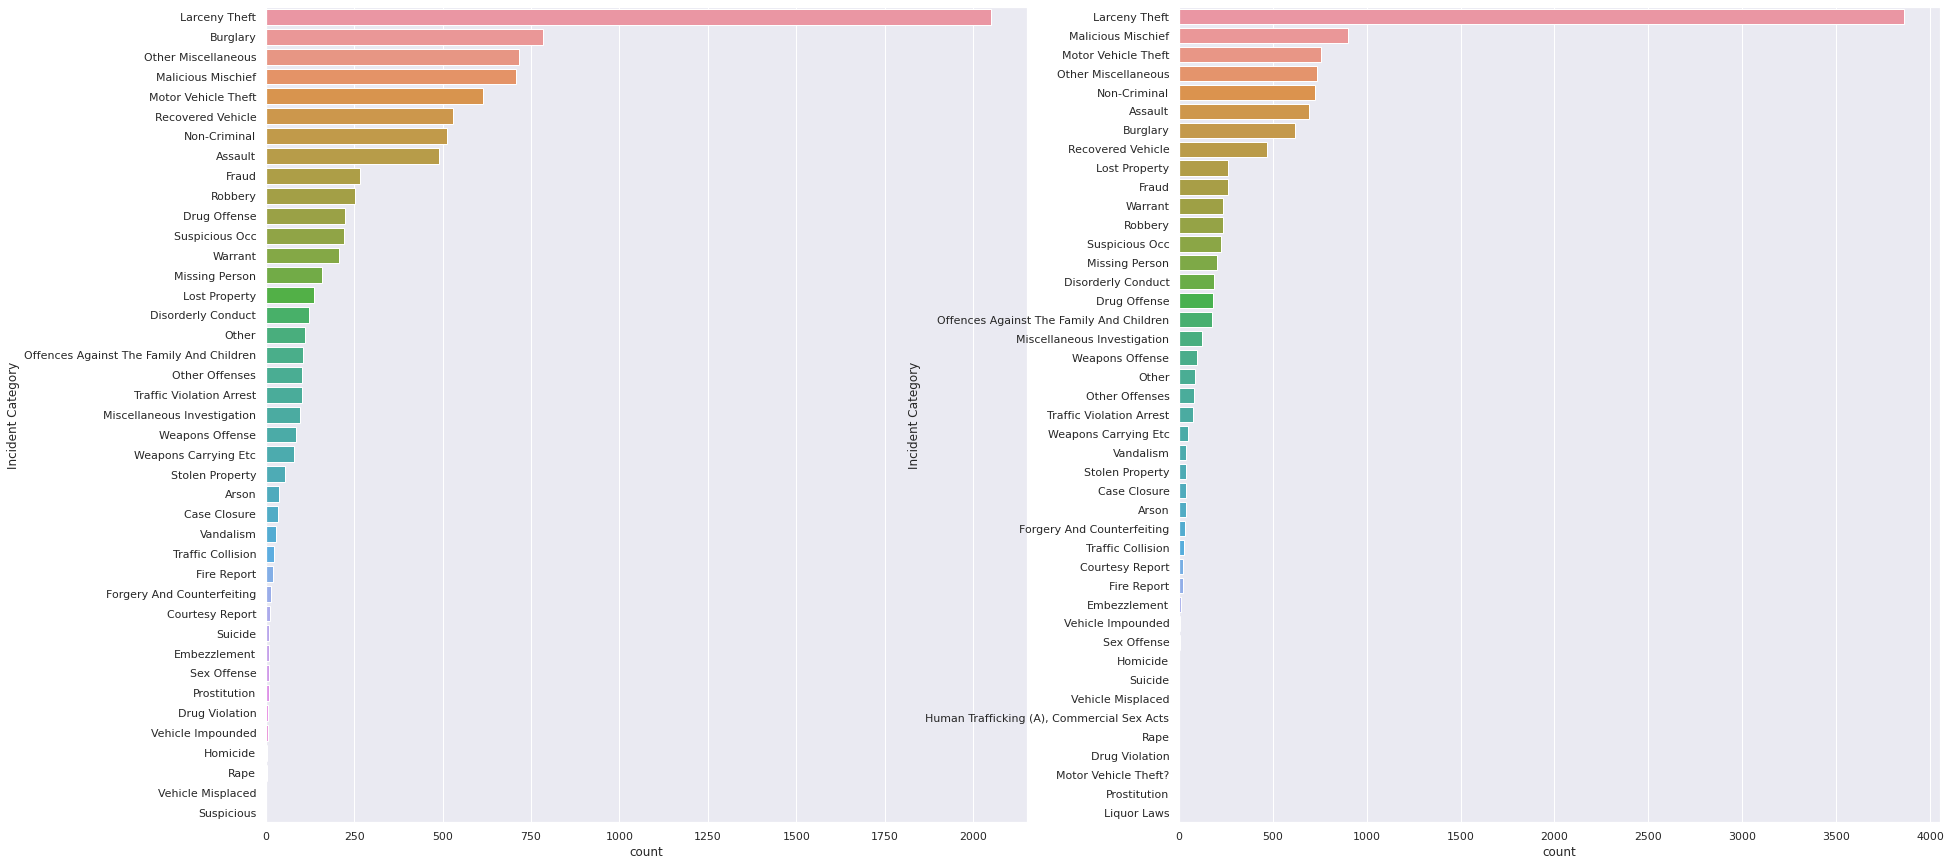

In [9]:
############ SUMMER ############
october_epoch = incidents_2021[incidents_2021['Incident Datetime'].between('2021-02-01', '2021-02-28')]
february_epoch = incidents_2021[incidents_2021['Incident Datetime'].between('2021-10-01', '2021-10-31')]

october_order = pd.Categorical(october_epoch['Incident Category'].value_counts().index)
february_order = pd.Categorical(february_epoch['Incident Category'].value_counts().index)

fig, ax =plt.subplots(1,2)
sns.countplot(data=october_epoch, y="Incident Category", order = october_order, ax=ax[0])
sns.countplot(data=february_epoch, y="Incident Category", order = february_order, ax=ax[1])

# print(incidents_2021['Incident Datetime'].count())
# incidents_2021['Incident Datetime'].plot()
# incidents_2021.groupby(['Incident Datetime']).mean()

# Incidentes más frecuentes Día/Noche
Analizaremos qué incidentes son más frecuentes en las horas diurnas y nocturnas 

In [10]:
daily_data_frame   = incidents_df[incidents_df['Incident Datetime'].dt.strftime("%H:%M:%S").between('07:00:00', '18:00:00')]
nightly_data_frame = incidents_df[incidents_df['Incident Datetime'].dt.strftime("%H:%M:%S").between('18:00:01', '23:59:59')]
nightly_data_frame = nightly_data_frame.append(incidents_df[incidents_df['Incident Datetime'].dt.strftime("%H:%M:%S").between('00:00:00', '06:59:59')])

daily_data_frame_order   = pd.Categorical(daily_data_frame['Incident Category'].value_counts().index)
nightly_data_frame_order = pd.Categorical(nightly_data_frame['Incident Category'].value_counts().index)

,Incident,Daily Percentage,Nightly Percentage,Difference (ABS)
5,Burglary,0.041951,0.076347,0.034397
2,Malicious Mischief,0.056771,0.081255,0.024484
3,Non-Criminal,0.068151,0.051204,0.016947
11,Drug Offense,0.030201,0.014517,0.015683
8,Warrant,0.035021,0.025241,0.009780
9,Fraud,0.033626,0.025414,0.008212
4,Assault,0.056530,0.064659,0.008130
7,Recovered Vehicle,0.040993,0.033365,0.007628
0,Larceny Theft,0.306641,0.299409,0.007232
10,Lost Property,0.032738,0.025850,0.006888


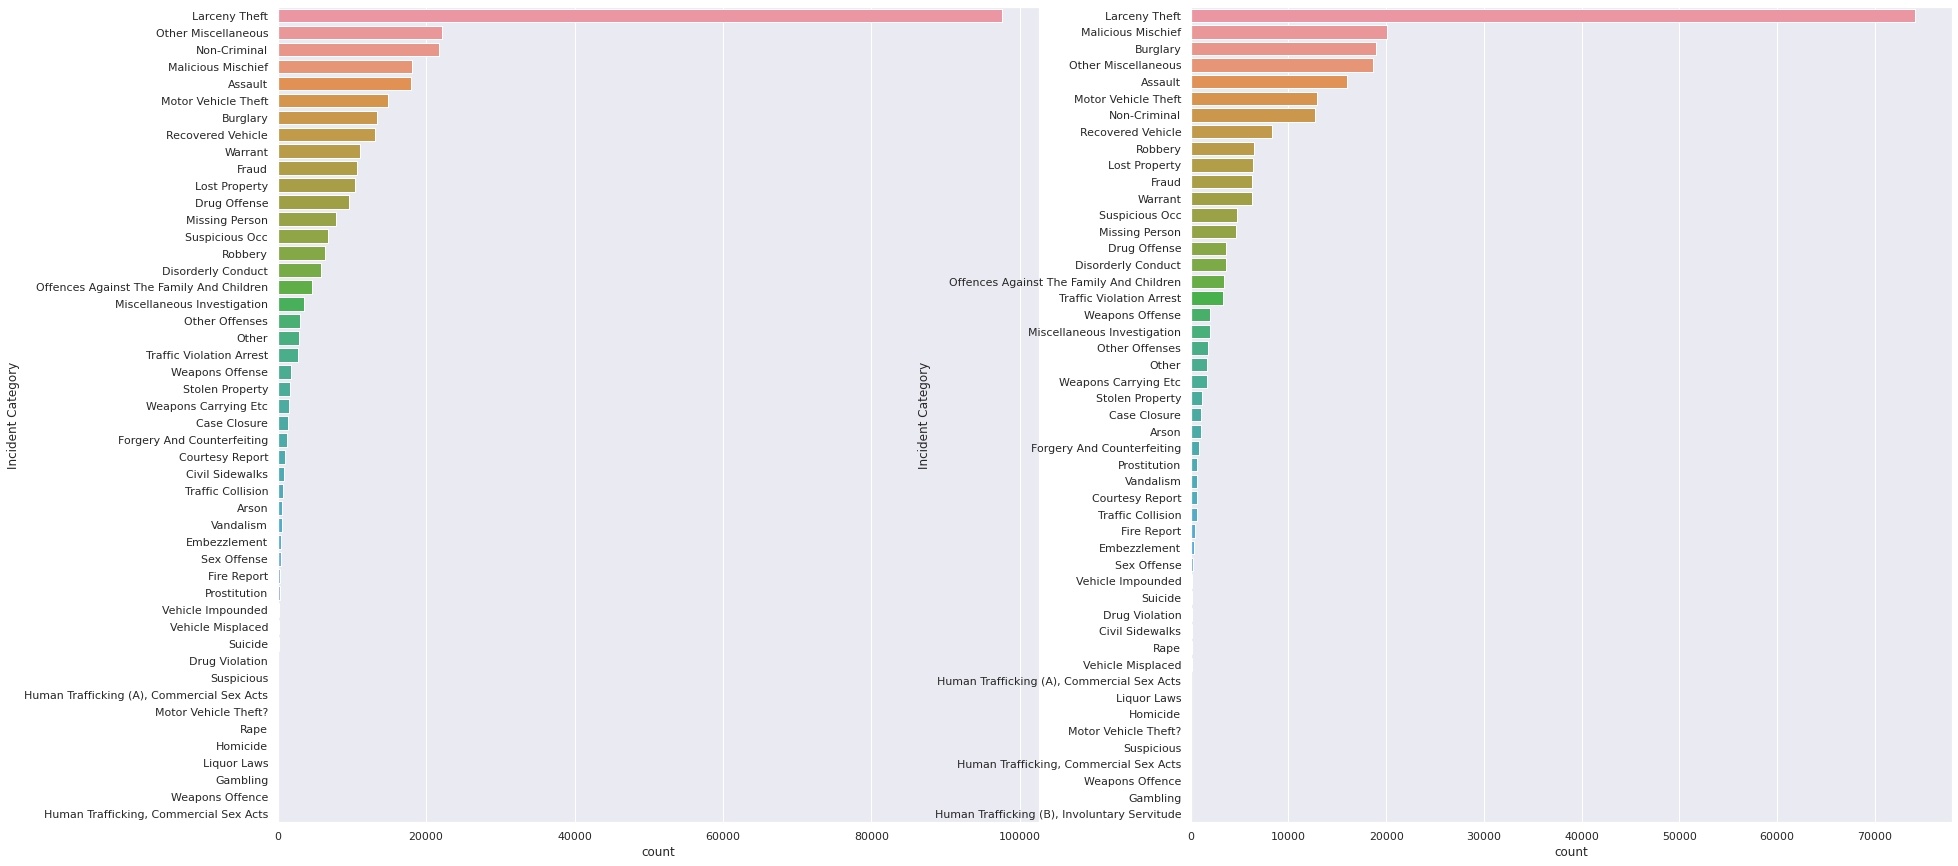

In [11]:
sns.set(rc={'figure.figsize':(30,15)})

fig, ax =plt.subplots(1,2)
sns.countplot(data=daily_data_frame, y="Incident Category", order = daily_data_frame_order, ax=ax[0])
sns.countplot(data=nightly_data_frame, y="Incident Category", order = nightly_data_frame_order, ax=ax[1])

difference_dataframe = pd.DataFrame(columns=['Incident', 'Daily Percentage', 'Nightly Percentage', 'Difference (ABS)'])

for incident in incidents_df['Incident Category'].value_counts().iteritems():
    day_percentage   = (daily_data_frame['Incident Category']   == incident[0]).sum() / len(daily_data_frame)
    night_percentage = (nightly_data_frame['Incident Category'] == incident[0]).sum() / len(nightly_data_frame)

    difference_dataframe = difference_dataframe.append({'Incident': incident[0],
                                                        'Daily Percentage': day_percentage,
                                                        'Nightly Percentage': night_percentage,
                                                        'Difference (ABS)': np.abs(day_percentage - night_percentage)},ignore_index=True)


difference_dataframe.sort_values('Difference (ABS)', ascending = False)

Podemos observar que se producen más incidentes por el día que por la noche

Más allanamiento por la noche

Más robos por la noche

Más drogas por el día

# Revisaremos la correlación de los datasets utilizando matrices de correlación:
1. Police Departmen Incidents
2. Schools College
3. Schools

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566245 entries, 216240 to 12211
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Incident Datetime             566245 non-null  datetime64[ns]
 1   Incident Date                 566245 non-null  object        
 2   Incident Time                 566245 non-null  object        
 3   Incident Year                 566245 non-null  int64         
 4   Incident Day of Week          566245 non-null  object        
 5   Report Datetime               566245 non-null  datetime64[ns]
 6   Incident Code                 566245 non-null  int64         
 7   Incident Category             565761 non-null  object        
 8   Incident Subcategory          565761 non-null  object        
 9   Incident Description          566245 non-null  object        
 10  Resolution                    566245 non-null  object        
 11  Intersect

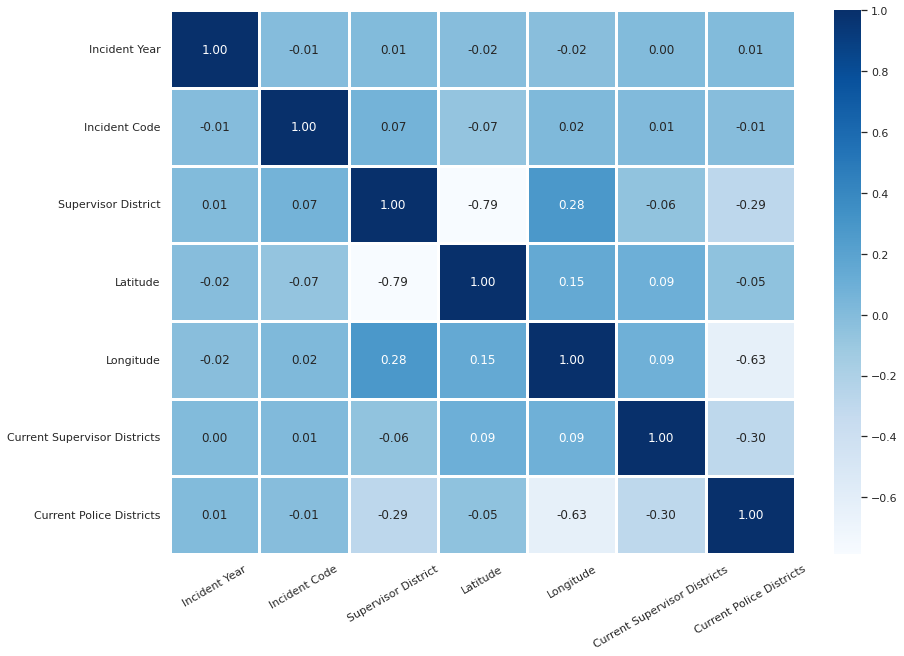

In [12]:
print(incidents_df.info())
#print(schools_df.info())
#print(colleges_df.info())


incidents = incidents_df.copy()#[['Platform', 'Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].groupby(by=['Platform']).sum()
#platform_sales = platform_sales.sort_values(by='Global_Sales', ascending=False)[:10]  # Nos quedamos con el Top 10
#for col in ['Report Type Description', 'Incident Category', 'Incident Category', 'Incident Subcategory', 'Incident Description', 'Resolution', 'Police District']:
#    incidents[col] = incidents[col].astype('category')

#incidents.drop(columns = ['Incident Datetime','Incident Date', 'Incident Time', 'Incident Day of Week', 'Report Datetime', 'Report Type Code', 'Report Type Description', 'Filed Online', 'Incident Category', 'Incident Subcategory', 'Incident Description', 'Resolution', 'Intersection', 'Police District', 'Analysis Neighborhood', 'Point'], axis = 1, inplace=True)
plt.figure(figsize=(14, 10))
sns.heatmap(incidents.corr('spearman'), annot=True, fmt='.2f', linewidth=3, cmap='Blues')
plt.yticks(rotation=0)
plt.xticks(rotation=30)
plt.show()

# Diagrama de Arbol de las "Categorías de Crimen" mas frecuentes

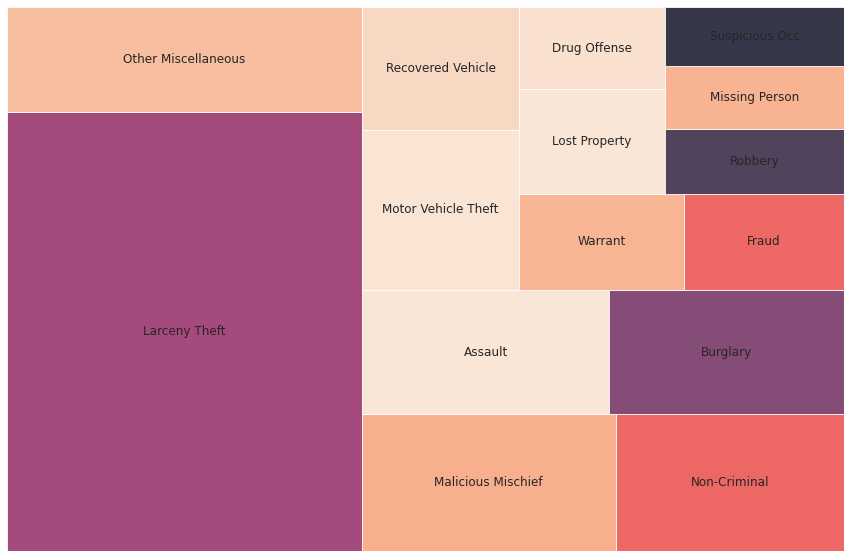

In [13]:
incidents_category = incidents_df['Incident Category'].value_counts()[:15].copy()

plt.figure(figsize=(15,10))
squarify.plot(sizes=incidents_category.values, label=incidents_category.index, alpha=.8)
plt.axis('off')
plt.show()

# Diagrama de Arbol de las "Subcategorías de Crimen" mas frecuentes

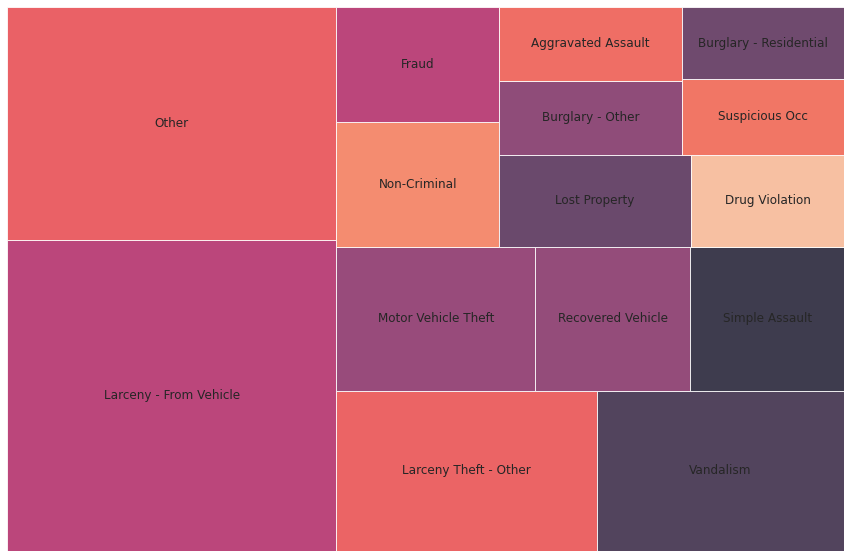

In [14]:
incidents_category = incidents_df['Incident Subcategory'].value_counts()[:15].copy()

plt.figure(figsize=(15,10))
squarify.plot(sizes=incidents_category.values, label=incidents_category.index, alpha=.8)
plt.axis('off')
plt.show()

# Nube de palabras para análizar las descripciones de los incidentes reportados

In [15]:
nlp = spacy.load('en_core_web_sm') # Utilizamo el SM porque no se puede cargar el Medium

list_words = [x.split() for x in incidents_df['Incident Description'].values]  # Obtenemos todas las palabras individuales para cada nombre
list_words = ' '.join([word for sublist in list_words for word in sublist])  # Las juntamos todas en un único texto
list_words = list_words[:1000000]

corpus = nlp(list_words)  # Procesamos las palabras con SpaCy
tokens = [w.lower_ for w in corpus if (not w.is_space and not w.is_punct)]  # Eliminamos espacios en blanco y signos de puntuación
corpus = ' '.join(tokens)  # Ya tenemos la lista de palabras limpia

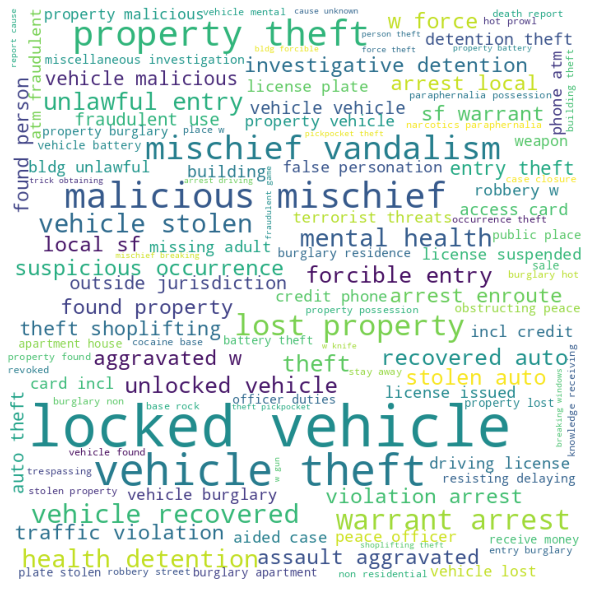

In [16]:
wordcloud = WordCloud(width=700, height=700, background_color='white', min_font_size=10).generate(corpus)
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad=0) 
plt.show()

## Calculamos el tiempo promedio de reporte por categoría de incidente

In [17]:
# sacar la proporcion de incidentes resueltos y no resueltos.
# Calcular el tiempo promedio de reporte de un incidente y ver si tiene algún sentido.
# obtenemos la diferencia de tiempo entre la fecha de reporte y la fecha del incidente.
incidents_df['Difference Date'] = abs(incidents_df['Incident Datetime'] - incidents_df['Report Datetime'])

## Tiempo promedio de reporte
Este es el top 15 de las categorías de incidentes que más demoran en reportarse.

Con este análisis tenemos que el tráfico de humanos ha demorado más en reportarse. Hay que considerar que en el dataset solo se cuenta con un registro.

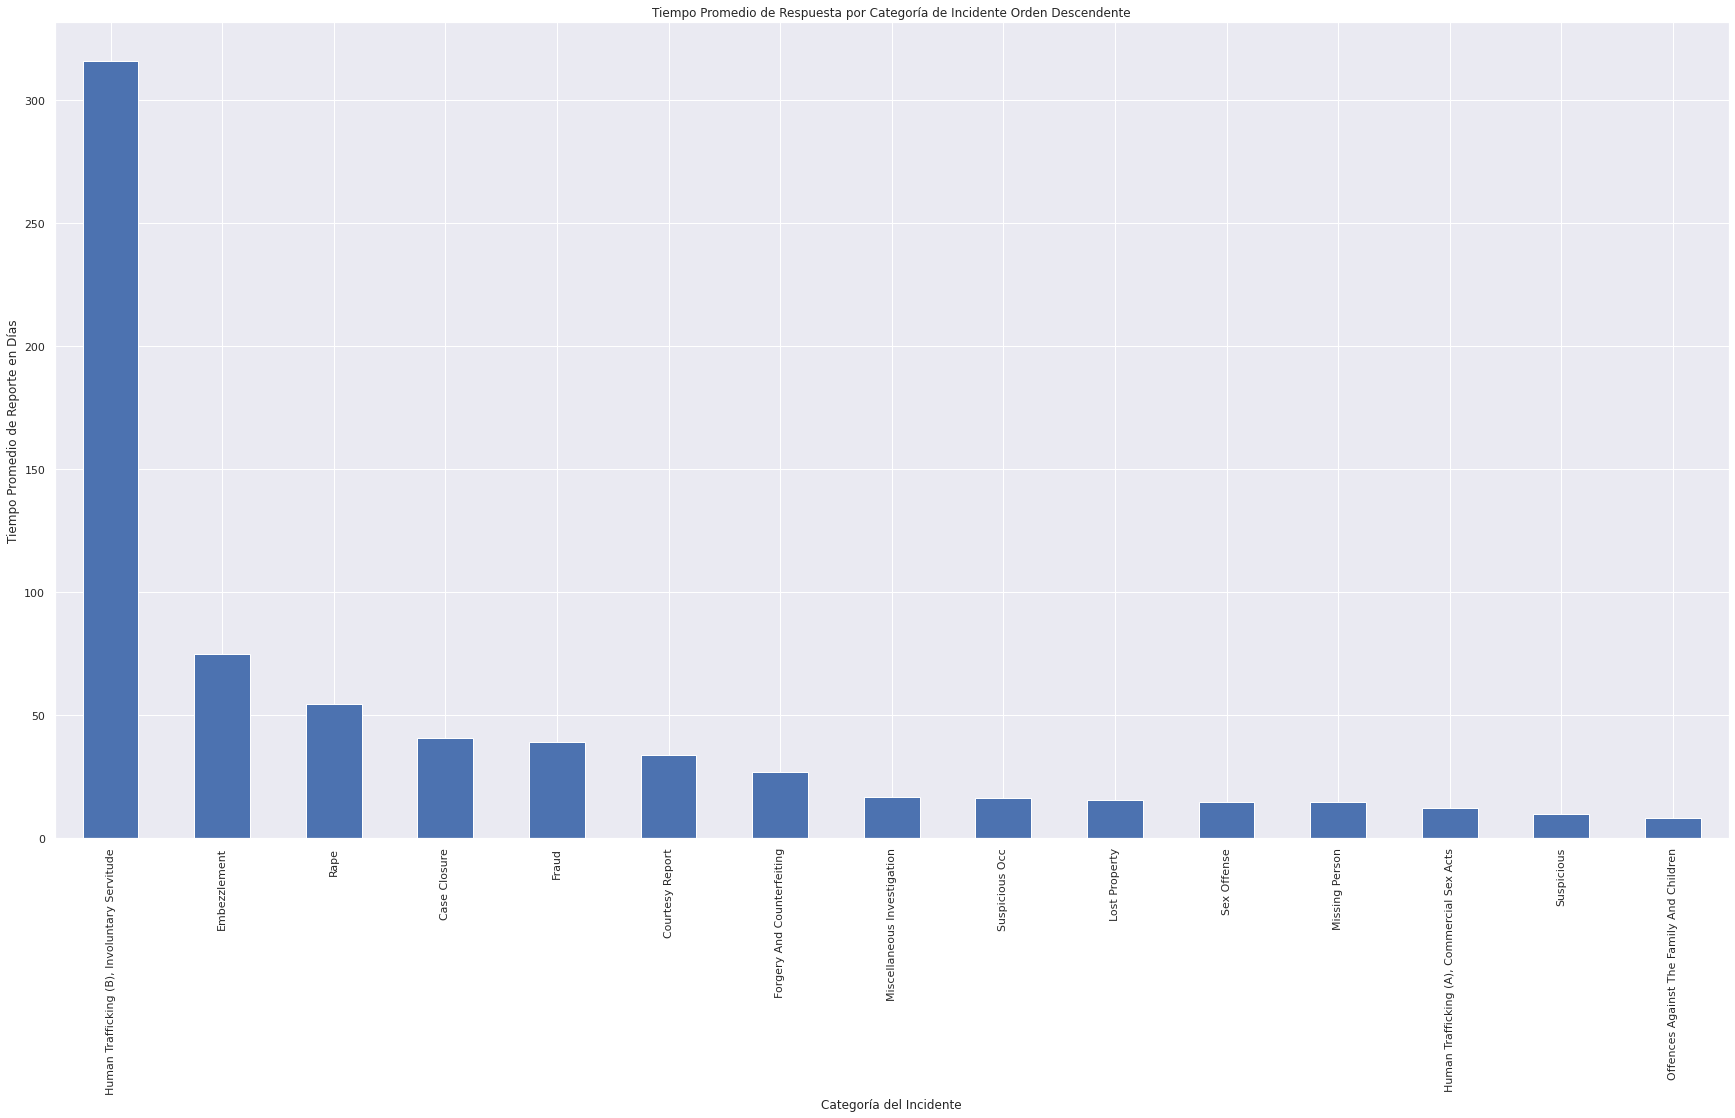

In [18]:


df_Test = incidents_df.groupby('Incident Category')['Difference Date'].mean().sort_values(ascending = False)[:15].astype('timedelta64[h]') / 24
df_Test.plot(kind = 'bar', title = 'Tiempo Promedio de Respuesta por Categoría de Incidente Orden Descendente', rot = 90)

plt.xlabel('Categoría del Incidente')
plt.ylabel('Tiempo Promedio de Reporte en Días')
plt.show()

Este es el top 15 de las categorías de incidentes que más rápido se reportan.

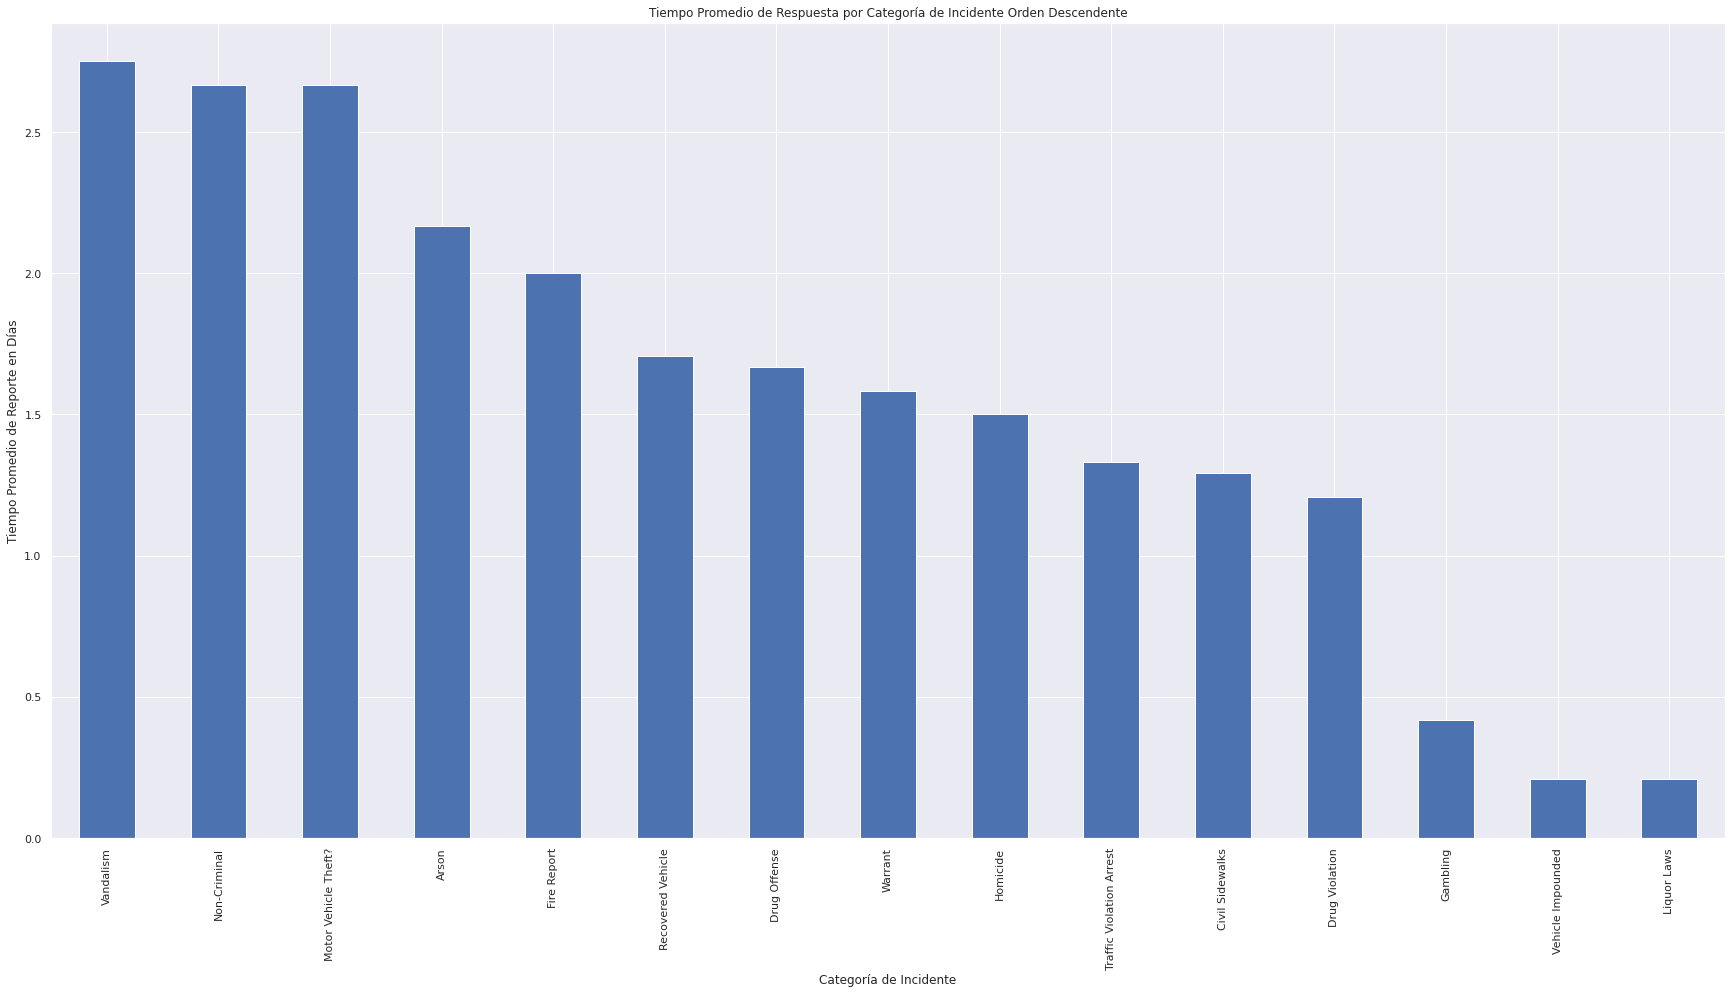

In [19]:
df_Test = incidents_df.groupby('Incident Category')['Difference Date'].mean().sort_values()[:15].sort_values(ascending = False).astype('timedelta64[h]') / 24
df_Test.plot(kind = 'bar', title = 'Tiempo Promedio de Respuesta por Categoría de Incidente Orden Descendente', rot = 90)

plt.xlabel('Categoría de Incidente')
plt.ylabel('Tiempo Promedio de Reporte en Días')
plt.show()

# Conclusión
---